# Business Problem

Description of the problem from the following website: https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/ 

Can you predict which water pumps are faulty?

Using data from Taarifa and the Tanzanian Ministry of Water, can you predict which pumps are functional, which need some repairs, and which don't work at all? This is an intermediate-level practice competition. Predict one of these three classes based on a number of variables about what kind of pump is operating, when it was installed, and how it is managed. A smart understanding of which waterpoints will fail can improve maintenance operations and ensure that clean, potable water is available to communities across Tanzania.

For the following notebook, I used data science methods to create a model that would be able to predict which water pumps could be accurately classified as "functional", "not functional", or "in need of repair". I used the OSEMN method to the best of my ability and chose the model with the highest accuracy score. 

# Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from helper import explore_column, model_helper


In [2]:
# explore_column(df, "status_group")

# Obtain

In [3]:
# Obtained two csv files for target variable and features. Merged the dataframes. 
target_df = pd.read_csv("training_set_labels.csv")
features_df = pd.read_csv("training_set_values.csv")
df = pd.merge(target_df, features_df, on="id")
df.head()

,id,status_group,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,functional,6000.0,3/14/2011,Roman,1390,Roman,34.938093,-9.856322,none,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,functional,0.0,3/6/2013,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,functional,25.0,2/25/2013,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,non functional,0.0,1/28/2013,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,functional,0.0,7/13/2011,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [4]:
# View dataframe statistics
# There are only 9 numerical columns. In light of this information, will make a vanilla model with only numerical 
# columns then add in categorical columns to see if that improves the results
df.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [5]:
# 40 variables that appear to be mostly string datatypes. A lot of the columns look like they could have similar information, 
# such as the three columns, "extraction_type", "extraction_type_group", and "extraction_type_class". They all have the same
# description as well, "The kind of extraction the waterpoint uses". Will look at getting rid of columns that are non needed 
# or are redundant. 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   status_group           59400 non-null  object 
 2   amount_tsh             59400 non-null  float64
 3   date_recorded          59400 non-null  object 
 4   funder                 55765 non-null  object 
 5   gps_height             59400 non-null  int64  
 6   installer              55745 non-null  object 
 7   longitude              59400 non-null  float64
 8   latitude               59400 non-null  float64
 9   wpt_name               59400 non-null  object 
 10  num_private            59400 non-null  int64  
 11  basin                  59400 non-null  object 
 12  subvillage             59029 non-null  object 
 13  region                 59400 non-null  object 
 14  region_code            59400 non-null  int64  
 15  di

In [6]:
# Using a bar chart to view the distribution of the target variable, "status_group". With there being three potential outcomes,
# this graph show that this is a multiclass classification problem that is imbalanced

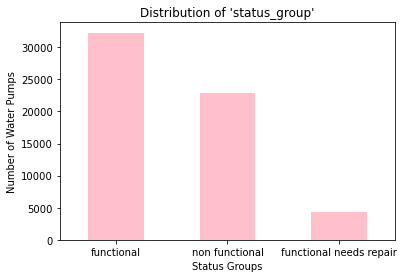

In [14]:
# View distribution of the "status_group" values
df['status_group'].value_counts().plot(kind='bar', color = "pink")
      
# giving title to the plot
plt.title("Distribution of 'status_group'")
      
# giving X and Y labels
plt.xlabel("Status Groups")
plt.xticks(rotation = 0)
plt.ylabel("Number of Water Pumps")

plt.show()

In [ ]:
# The percentage of "functional needs repair" is very low compared to the other two options. Since
# there are so few, I'm going to drop those values from the status_group column in order to solve the class
# imbalance problem
df['status_group'].value_counts(normalize=True)

In [ ]:
# Dropping "functional needs repair"
df = df[df.status_group != "functional needs repair"]

In [ ]:
# Confirming the drop
df['status_group'].value_counts(normalize=True)

# Scrub/Explore

In [ ]:
# For the first vanilla model, I'll use the numerical columns from the dataset.
# I'll approach this problem by using a forward selection method, but for that, I'll first use the 
# numerical columns and add features from there. 

In [ ]:
# Numerical columns
numerical_columns = df.select_dtypes("number")
numerical_columns.head(2)

In [ ]:
# Next step after trying the vanilla decision tree model and the random forest model, 
# use the models to decide on feature importance for the next categorical feature.
# Based off the two models, the features that were most important were geographical, so
# my next categorical feature will be on that is geographical. In the dataset, there are a few
# that fit that description, "basin", "subvillage", "region", "lga", "ward". I'll take a look at
# the content of each column to make my decision for the next feature

In [ ]:
# Explore the "basin", "subvillage", "region", "region", "lga" columns

In [ ]:
explore_column(df, "basin")

In [ ]:
explore_column(df, "subvillage")

In [ ]:
explore_column(df, "region")

In [ ]:
explore_column(df, "lga")

In [ ]:
explore_column(df, "ward")

### Adding "basin" column

In [ ]:
# Based of the number of unique values per column, my second categorical choice for a column
# will be "basin".

In [ ]:
# Graph to show distribution of "basin" values
df['basin'].value_counts().plot(kind='bar')

# giving title to the plot
plt.title("Distribution of 'basin'")
      
# giving X and Y labels
plt.xlabel("Basins")
plt.ylabel("Amount")

plt.show()

In [ ]:
# Check for missing values
df["basin"].isnull().sum()

In [ ]:
# Add "basin" column
df_basin = pd.concat([numerical_columns, df['basin']], axis=1)
df_basin.head(2)

In [ ]:
# Dummy code "basin"
df_dummy_basin = pd.get_dummies(df_basin, drop_first=True)
print('Shape before dummy coding: ', df_basin.shape)
print('Shape after dummy coding: ', df_dummy_basin.shape)

In [ ]:
# Check dataframe
df_dummy_basin.head(2)

In [ ]:
# Based of the second iteration of models, it looks like there was slight improvement with the addition of the dummy "basin"
# column. Next step would be to add another geographical categorical column, and from further exploration, "region"
# is the next best choice.

### Adding "region" column

In [ ]:
# Graph to show distribution of "region" values 
df['region'].value_counts().plot(kind='bar')

# giving title to the plot
plt.title("Distribution of 'region'")
      
# giving X and Y labels
plt.xlabel("Regions")
plt.ylabel("Number of waterpumps per region")

plt.show()

In [ ]:
# Add "region" column
df_region = pd.concat([df_dummy_basin, df['region']], axis=1)
df_region.head(2)

In [ ]:
# Dummy code "region"
df_dummy_region = pd.get_dummies(df_region, drop_first=True)

print('Shape before dummy coding: ', df_dummy_basin.shape)

print('Shape after dummy coding: ', df_dummy_region.shape)

In [ ]:
# Check dataframe
df_dummy_region.head(2)

#### Fourth iteration of models

In [ ]:
# View original dataframe columns
df.info()

In [ ]:
explore_column(df, "water_quality")

In [ ]:
explore_column(df, "quality_group")

### Adding "quality_group" column 

In [ ]:
# Next step will be to add another categorical variable. I'll be adding "quality_group" to the dataframe.

In [ ]:
# Graph to show distribution of "basin" values 
df['quality_group'].value_counts().plot(kind='bar')

# giving title to the plot
plt.title("Distribution of 'quality_group'")
      
# giving X and Y labels
plt.xlabel("Quality Groups")
plt.ylabel("Amount per group")

plt.show()

In [ ]:
# Add "quality_group" column
df_quality_group = pd.concat([df_dummy_region, df["quality_group"]], axis=1)
df_quality_group.head(2)

In [ ]:
# Dummy code "quality_group"
df_dummy_quality_group = pd.get_dummies(df_quality_group, drop_first=True)

print('Shape before dummy coding: ', df_dummy_region.shape)
print('Shape after dummy coding: ', df_dummy_quality_group.shape)

In [ ]:
df_dummy_quality_group.head(2)

In [ ]:
# For the fifth iteration of the models, I'd like to try a column that focuses on the "extraction_type"

In [ ]:
explore_column(df, "extraction_type")

In [ ]:
explore_column(df, "extraction_type_group")

In [ ]:
explore_column(df, "extraction_type_class")

### Adding "extraction_type_class" column

In [ ]:
# After a look at the three similar variables, I'll use the "extraction_type_class" as my next categorical column

In [ ]:
# Graph to show distribution of "basin" values 
df['extraction_type_class'].value_counts().plot(kind='bar')

# giving title to the plot
plt.title("Distribution of 'extraction_type_class'")
      
# giving X and Y labels
plt.xlabel("Extraction types")
plt.ylabel("Amount")

plt.show()

In [ ]:
# Add "extraction_type_class" column
df_extraction_type_class = pd.concat([df_dummy_quality_group, df["extraction_type_class"]], axis=1)
df_extraction_type_class

In [ ]:
# Dummy code "extraction_type_class"
df_dummy_extraction_type_class = pd.get_dummies(df_extraction_type_class, drop_first=True)

print('Shape before dummy coding: ', df_dummy_quality_group.shape)
print('Shape after dummy coding: ', df_dummy_extraction_type_class.shape)

In [ ]:
# Check new dataframe looks as is expected
df_dummy_extraction_type_class.head(2)

### Feature engineering the numerical columns "construction_year" and "gps_height"

In [ ]:
# Feature Engineering
# For the construction_year and gps_height I used the median of them to replace the 0 values.

### "construction_year"

In [ ]:
# View the distribution of the column
sns.histplot(numerical_columns['construction_year'], kde=True, stat="density", linewidth=0)

# giving title to the plot
plt.title("Distribution of 'construction year'")

plt.show()

In [ ]:
explore_column(df, "construction_year")

In [ ]:
# This column has a lot of zeros. I'll replace the zero values with the column median
construction_year_median = numerical_columns['construction_year']
construction_year_median.replace(to_replace = 0, value = construction_year_median.median(), inplace=True)

### "gps_height"

In [ ]:
explore_column(df, "gps_height")

In [ ]:
# View the distribution of the column
sns.histplot(numerical_columns['gps_height'], kde=True, stat="density", linewidth=0)

# giving title to the plot
plt.title("Distribution of 'gps_height'")

plt.show()

In [ ]:
# This column also had a disproportial amount of zeros. I'll also replace the zero values with the column median
gps_height_median = numerical_columns['gps_height']
gps_height_median.replace(to_replace = 0, value = gps_height_median.median(), inplace=True)

In [ ]:
# Check zeros have been successfully converted to median 
numerical_columns["gps_height"].value_counts()

# Model

## First iteration of models with only numerical columns

In [ ]:
# Including only the numerical columns as the X variable for first iteration 
X = numerical_columns.drop("id", axis=1)
y = df["status_group"]

### Fit first logistic regression

In [ ]:
lg1 = model_helper(X, y, LogisticRegression(random_state = 11, max_iter = 1000))

### Fit first decision tree

In [ ]:
dt1 = model_helper(X, y, DecisionTreeClassifier(max_depth = 10), feature_importance = True)

### Fit first random forest

In [ ]:
rf1 = model_helper(X, y, RandomForestClassifier(max_depth = 10, random_state = 11), feature_importance = True)

## Second iteration of models with added categorical column, "basin"

In [ ]:
# Add in the new X variable, df_dummy_basin, along with the previous numerical columns
X = df_dummy_basin.drop("id", axis=1)

y = df["status_group"]

### Fit second logistic regression

In [ ]:
lg2 = model_helper(X, y, LogisticRegression(random_state=11, max_iter=1000))

### Fit second decision tree

In [ ]:
dt2 = model_helper(X, y, DecisionTreeClassifier(max_depth=10), feature_importance = True)

### Fit second random forest

In [ ]:
rf2 = model_helper(X, y, RandomForestClassifier(max_depth=10), feature_importance = True)

## Third iteration of models with added dummified categorical column, "region"

In [ ]:
# Add in the new X variable, df_dummy_region
X = df_dummy_region.drop("id", axis=1)

y = df["status_group"]

### Fit third logistic regression

In [ ]:
lg3 = model_helper(X, y, LogisticRegression(random_state = 11, max_iter = 2000))

### Fit third decision tree

In [ ]:
dt3 = model_helper(X, y, DecisionTreeClassifier(max_depth = 10), feature_importance = True)

### Fit third random forest

In [ ]:
rf3 = model_helper(X, y, RandomForestClassifier(max_depth = 10, random_state = 11), feature_importance = True)

In [ ]:
# Based off the feature importances of the highest perform model with the third iteration, it looks like the dummified 
# "region" column made a slight improvement to the test score

## Fourth iteration of models with added dummified categorical column, "quality_group"

In [ ]:
# Add in the new X variable, df_dummy_quality_group
X = df_dummy_quality_group.drop("id", axis=1)

y = df["status_group"]

### Fit fourth logistic regression

In [ ]:
lg4 = model_helper(X, y, LogisticRegression(random_state = 11, max_iter = 2000)) 

### Fit fourth decision tree

In [ ]:
dt4 = model_helper(X, y, DecisionTreeClassifier(max_depth = 10), feature_importance = True)

### Fit fourth random forest

In [ ]:
rf4 = model_helper(X, y, RandomForestClassifier(max_depth = 10, random_state = 11), feature_importance = True)

## Fifth iteration of models with added dummified categorical column, "quality_group"

In [ ]:
# Add in the new X variable, df_dummy_extraction_type
X = df_dummy_extraction_type_class.drop("id", axis=1)

y = df["status_group"]

### Fit fifth logistic regression

In [ ]:
lg5 = model_helper(X, y, LogisticRegression(random_state = 11, max_iter = 2000))

### Fit fifth decision tree

In [ ]:
dt5 = model_helper(X, y, DecisionTreeClassifier(max_depth = 10), feature_importance = True)

### Fit fifth random forest

In [ ]:
rf5 = model_helper(X, y, RandomForestClassifier(max_depth = 20, random_state = 11), feature_importance = True)

### Testing fifth random forest model with test values

In [ ]:
test_df = pd.read_csv("test_df.csv")
test_df.head(2)

In [ ]:
my_ids = test_df["id"]
my_ids.head(2)

In [ ]:
test_df.drop("id", axis = 1, inplace = True)

In [ ]:
test_df.head(2)

In [ ]:
rf_final = model_helper(X, y, RandomForestClassifier(max_depth = 20, random_state = 11), feature_importance = True)

In [ ]:
test_df

In [ ]:
rf_final.predict(test_df)

In [ ]:
submission = pd.DataFrame({'id': my_ids, 'status_group': rf5.predict(test_df[X_train.columns])})
submission.to_csv('submission.csv', index=False)

In [ ]:
submission.head()

In [ ]:
# View feature importance
feat_import = pd.DataFrame({'features': X_train.columns, 'importance': rf5.feature_importances_})
feat_import.sort_values('importance', ascending=False)

# Interpret

The fifth random forest with the specifications of a max_depth of 20 proved to be the best model for the training set. The 
accuracy on the training score was left at a 0.931 with the testing score left at 0.811. This showed some overfitting on the 
the training set, but the overall testing score was the highest from all the models, so I decided that'd be the best model
to choose. After applying my best model, the fifth random forest, I added it to the competition website and had an overall score of 0.7525 with my current rank being 4,557 out of 14,106 other competitors. 


## Future Work

For future work, I'd be interested in adding more categorical variables and studying how those affect the models. 